In [1]:
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     
import torch
import tigramite
import tqdm
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from statsmodels.tools.sm_exceptions import InterpolationWarning
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.gpdc import GPDC
import seaborn as sns

In [1]:
link_assumptions = {j:{(i, -tau):'' for i in range(8) for tau in range(2) if (i, -tau) != (j, 0)} 
                            for j in range(8)}
link_assumptions[0][(1, 0)] = '<?-' #Nd is an ancestor of P
link_assumptions[1][(0, 0)] = '-?>'
link_assumptions[7][(1, 0)] = '<?-'# CF is an ancestor of precipitation
link_assumptions[1][(7, 0)] = '-?>'
link_assumptions[0][(0, -1)] = '-?>' #Nd at lag t-1 is an ancestor of Nd
link_assumptions[0][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of Nd
link_assumptions[7][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of CF
link_assumptions[7][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of CF
link_assumptions[1][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of P
link_assumptions[1][(7, -1)] = 'o?>' #CF at lag -1 is an ancestor of P
link_assumptions[7][(7, -1)] = 'o?>' #CF at lag t-1 is an ancestor of CF
for j in range(2,7): 
    link_assumptions[j][(0, 0)] = '<?-' #meterological variables are ancestor of aerosol
    link_assumptions[0][(j, 0)] = '-?>'
    link_assumptions[j][(7, 0)] = '<?-' #meteorological variables are ancestor of cloud fraction
    link_assumptions[7][(j, 0)] = '-?>'

{0: {(0, -1): '', (1, 0): '', (1, -1): '', (2, 0): '', (2, -1): '', (3, 0): '', (3, -1): '', (4, 0): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '', (7, -1): ''}, 1: {(0, 0): '', (0, -1): '', (1, -1): '', (2, 0): '', (2, -1): '', (3, 0): '', (3, -1): '', (4, 0): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '', (7, -1): ''}, 2: {(0, 0): '', (0, -1): '', (1, 0): '', (1, -1): '', (2, -1): '', (3, 0): '', (3, -1): '', (4, 0): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '', (7, -1): ''}, 3: {(0, 0): '', (0, -1): '', (1, 0): '', (1, -1): '', (2, 0): '', (2, -1): '', (3, -1): '', (4, 0): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '', (7, -1): ''}, 4: {(0, 0): '', (0, -1): '', (1, 0): '', (1, -1): '', (2, 0): '', (2, -1): '', (3, 0): '', (3, -1): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '', (7, -1): ''}, 5: {(0, 0): '', (0, -1): '', (1, 0

In [3]:
dat = pd.read_csv('/home/gnicolaou/tigramite/tutorials/causal_discovery/data.csv')
dat = dat.values
n_a_n = np.isnan(dat).any(axis=1)
dat[n_a_n] = 999

# initialize dataframe object, specify variable names
var_names = ['Nd','Pr','sst','lts','fth','ws','div','cf']
dataframe = pp.DataFrame(dat, var_names=var_names, missing_flag = 999)

#gpdc = GPDC(significance='analytic', gp_params=None)
#cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks', sig_samples=200)
cmi_knn = CMIknn(significance='fixed_thres', model_selection_folds=3)

pcmci_cmi = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=0)
results = pcmci_cmi.run_lpcmci(tau_max=2, pc_alpha = .05, link_assumptions = link_assumptions)
print(results)

tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'], save_name = "sim_data_cmiknn.1.linkass.png")



: 

In [ ]:
import numpy as np
# Create an array of zeros with the desired shape and data type
final_arr_values = np.zeros((8, 8, 3), dtype=object)

# Iterate over each element and replace it with a vector of 1000 zeros
for i in range(final_arr_values.shape[0]):
    for j in range(final_arr_values.shape[1]):
        for k in range(final_arr_values.shape[2]):
            final_arr_values[i, j, k] = np.zeros(1000, dtype=int)

In [ ]:
#print(results['graph'])
final_arr = np.zeros((8, 8, 3), dtype=int)
final_arr[results['graph'] != ''] = 1

In [3]:
data = pd.read_csv('/home/gnicolaou/tigramite/tutorials/causal_discovery/data.csv')
def sample_trajectories(df, n_trajectories):
    max_index = df.index.max()
    trajectory_length = df[df.isna().all(axis=1)].index[0] + 1 # Length of each trajectory
    sampled_indices = np.random.choice(range(0, max_index, trajectory_length), size=n_trajectories, replace=True)
    sampled_trajectories = []
    for idx in sampled_indices:
        sampled_trajectories.append(df.iloc[idx:idx+trajectory_length])
    return pd.concat(sampled_trajectories)

# Example usage:
# Assuming df is your DataFrame with trajectories as described
sampled_df = sample_trajectories(data, n_trajectories=2)  # Sampling 100 trajectories
print(sampled_df.head())

                0         1          2          3         4         5  \
17980   89.386970  0.227354  293.28082  24.280912  0.000233  7.496290   
17981  131.712360  0.009226  294.82202  19.202335  0.000373  7.994742   
17982   48.906640  0.032487  294.08554  14.370646  0.003779  3.151628   
17983   62.857050  0.020456  295.94275  17.066334  0.003617  2.607422   
17984   47.383667  0.012148  294.67212  22.873160  0.000329  7.412026   

              6         7  
17980  0.000017  0.929443  
17981  0.000012  0.429688  
17982 -0.000006  0.376709  
17983  0.000001  0.158447  
17984  0.000008  0.334961  


In [4]:
integer = 1000

cmi_knn = CMIknn(significance='fixed_thres', model_selection_folds=3)
#gpdc = GPDC(significance='analytic', gp_params=None)
final_arr = np.zeros((8, 8, 3), dtype=int)
for i in range(0, integer):
    sampled_df = sample_trajectories(data, n_trajectories=50)
    dat = sampled_df.values
    n_a_n = np.isnan(dat).any(axis=1)
    dat[n_a_n] = 999
    # initialize dataframe object, specify variable names
    var_names = ['Nd','Pr','sst','lts','fth','ws','div','cf']
    dataframe = pp.DataFrame(dat, var_names=var_names, missing_flag = 999)
    pcmci_cmi = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=0)
    results = pcmci_cmi.run_lpcmci(tau_max=2, pc_alpha = .05)
    new_arr = np.zeros_like(results['graph'], dtype=int)
    new_arr[results['graph'] != ''] = 1
    final_arr = final_arr + new_arr
    for p in range(final_arr_values.shape[0]):
        for j in range(final_arr_values.shape[1]):
            for k in range(final_arr_values.shape[2]):
                final_arr_values[p, j, k][i] = results['val_matrix'][p, j, k]

print(final_arr / integer)


[[[0.    0.    0.   ]
  [0.154 0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.928 0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]]

 [[0.154 0.    0.   ]
  [0.    0.081 0.003]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [1.    0.    0.   ]]

 [[0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.022 0.    0.   ]
  [0.973 0.    0.   ]
  [0.514 0.    0.   ]
  [0.    0.    0.   ]
  [0.074 0.    0.   ]]

 [[0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.022 0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [1.    0.    0.   ]
  [0.    0.    0.   ]
  [0.205 0.    0.   ]]

 [[0.928 0.    0.   ]
  [0.    0.    0.   ]
  [0.973 0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.913 0.    0.   ]
  [0.    0.    0.   ]
  [0.    0.    0.   ]]

 [[0.    0.    0.   ]
  [0.    0.    0.   ]
  [0.514 0.    0.   ]
  [1.    0.    0.   ]
  [0.913 0.    0.   ]


In [9]:
new_array = np.where(final_arr/integer != 0, '->', '')

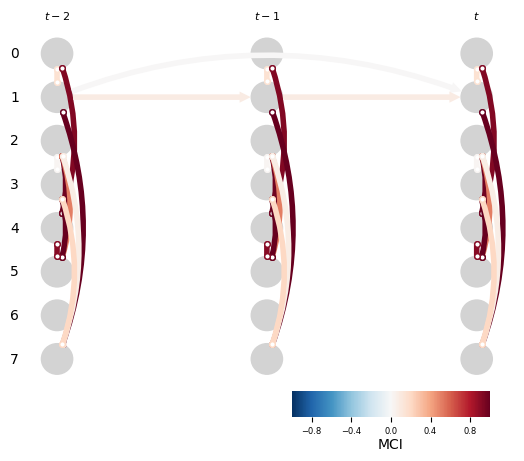

In [10]:
tp.plot_time_series_graph(graph=new_array,
                          val_matrix=final_arr / integer)
plt.show()

In [ ]:
import numpy as np

# Assuming new_array is your (8, 8, 3) array where each element contains a 1000-long array of values

# Define the confidence interval range (e.g., 95%)
confidence_interval = 95

# Create a new array to store the confidence intervals
confidence_intervals = np.zeros((8, 8, 3), dtype=object)

# Iterate over each element and replace it with a vector of 1000 zeros
for i in range(confidence_intervals .shape[0]):
    for j in range(confidence_intervals .shape[1]):
        for k in range(confidence_intervals.shape[2]):
            confidence_intervals [i, j, k] = np.zeros(2, dtype=int)
#confidence_intervals = np.zeros_like(final_arr_values, dtype=np.float64)

# Iterate over each element of new_array
for i in range(final_arr_values.shape[0]):
    for j in range(final_arr_values.shape[1]):
        for k in range(final_arr_values.shape[2]):
            # Calculate the confidence interval for the current element
            lower_bound = np.percentile(final_arr_values[i, j, k], (100 - confidence_interval) / 2)
            upper_bound = np.percentile(final_arr_values[i, j, k], confidence_interval + (100 - confidence_interval) / 2)
            
            # Store the confidence interval in confidence_intervals array
            confidence_intervals[i, j, k] = [lower_bound, upper_bound]

# confidence_intervals now contains the confidence intervals for each element in new_array

print(confidence_intervals)